In [25]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [26]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


In [27]:
lat = 35.01
long = -80.95

In [28]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": lat,
	"longitude": long,
	"daily": ["sunset", "sunrise", "temperature_2m_max", "temperature_2m_min"],
	"hourly": ["temperature_2m", "relative_humidity_2m", "cloud_cover", "precipitation_probability", "precipitation", "apparent_temperature", "dew_point_2m"],
	"forecast_days": 16,
	"wind_speed_unit": "ms",
}
responses = openmeteo.weather_api(url, params=params)

In [29]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

Coordinates: 35.01469421386719°N -80.94395446777344°E
Elevation: 195.0 m asl
Timezone: NoneNone
Timezone difference to GMT+0: 0s


In [30]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(5).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time() + response.UtcOffsetSeconds(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd() + response.UtcOffsetSeconds(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["precipitation_probability"] = hourly_precipitation_probability
hourly_data["precipitation"] = hourly_precipitation
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["dew_point_2m"] = hourly_dew_point_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n")
hourly_dataframe


Hourly data



,date,temperature_2m,relative_humidity_2m,cloud_cover,precipitation_probability,precipitation,apparent_temperature,dew_point_2m
0,2026-02-05 00:00:00+00:00,2.074,74.0,100.0,28.0,0.0,-2.206695,-2.077723
1,2026-02-05 01:00:00+00:00,2.874,89.0,100.0,18.0,0.0,-1.000767,1.239760
2,2026-02-05 02:00:00+00:00,2.974,92.0,100.0,11.0,0.0,-0.922718,1.801512
3,2026-02-05 03:00:00+00:00,2.824,92.0,100.0,9.0,0.0,-0.842357,1.652938
4,2026-02-05 04:00:00+00:00,2.574,95.0,100.0,13.0,0.0,-1.385229,1.853748
...,...,...,...,...,...,...,...,...
379,2026-02-20 19:00:00+00:00,17.448,83.0,100.0,16.0,0.5,15.289906,14.529517
380,2026-02-20 20:00:00+00:00,15.448,80.0,100.0,16.0,0.5,12.209812,12.013613
381,2026-02-20 21:00:00+00:00,13.748,78.0,100.0,16.0,0.5,9.668678,9.979397
382,2026-02-20 22:00:00+00:00,12.798,79.0,100.0,16.0,0.0,8.913512,9.246170


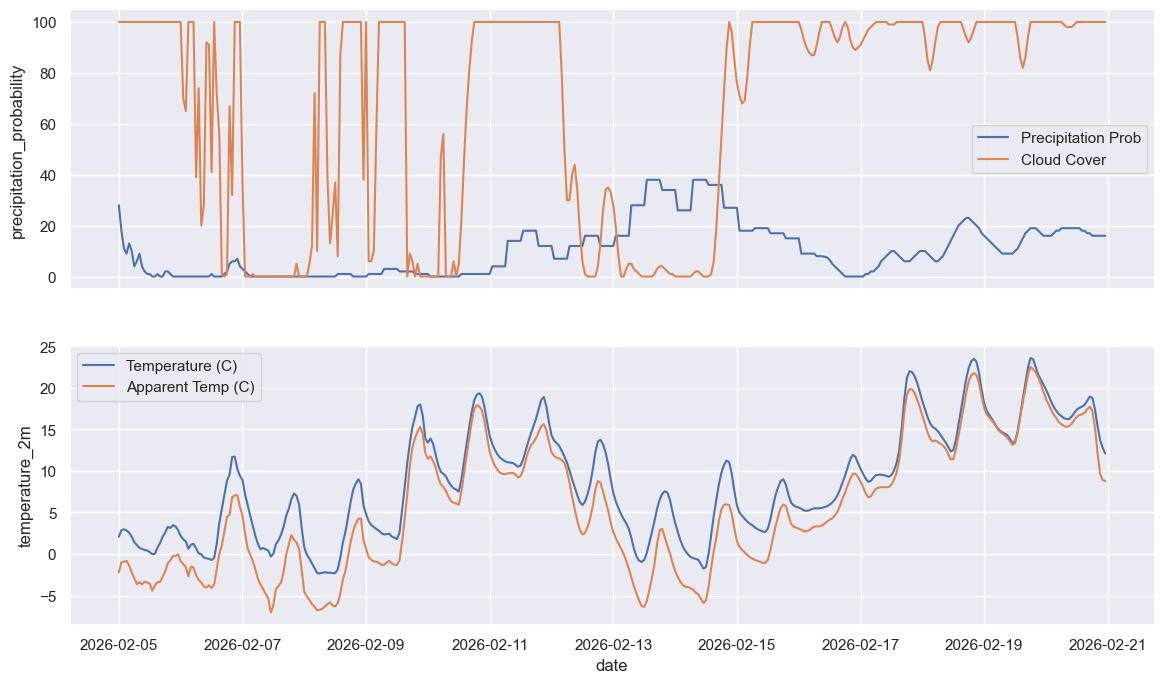

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
sns.lineplot(data=hourly_dataframe, x='date',y='precipitation_probability', ax=ax1, label = 'Precipitation Prob')
sns.lineplot(data=hourly_dataframe, x='date',y='cloud_cover', ax=ax1, label = 'Cloud Cover')
sns.lineplot(data=hourly_dataframe, x='date',y='temperature_2m',ax=ax2, label = 'Temperature (C)')
sns.lineplot(data=hourly_dataframe, x='date',y='apparent_temperature',ax=ax2, label = 'Apparent Temp (C)')
plt.legend()
plt.show()

In [32]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_sunset = daily.Variables(0).ValuesInt64AsNumpy()
daily_sunrise = daily.Variables(1).ValuesInt64AsNumpy()
daily_temperature_2m_max = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(3).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time() + response.UtcOffsetSeconds(), unit = "s", utc = True),
	end =  pd.to_datetime(daily.TimeEnd() + response.UtcOffsetSeconds(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["sunset"] = pd.to_datetime(daily_sunset, unit='s', utc=True)
daily_data["sunrise"] = pd.to_datetime(daily_sunrise, unit='s', utc=True)
daily_data['daylight'] = daily_data["sunset"] - daily_data["sunrise"]
daily_data['daylight_duration'] = daily_data['daylight'].total_seconds()/3600
daily_data["temperature_max"] = daily_temperature_2m_max
daily_data["temperature_min"] = daily_temperature_2m_min


daily_dataframe = pd.DataFrame(data = daily_data)
daily_dataframe.drop(columns = ['daylight'], inplace=True)
print("\nDaily data\n")
daily_dataframe


Daily data



,date,sunset,sunrise,daylight_duration,temperature_max,temperature_min
0,2026-02-05 00:00:00+00:00,2026-02-05 22:56:25+00:00,2026-02-05 12:18:58+00:00,10.624167,3.474000,-0.026
1,2026-02-06 00:00:00+00:00,2026-02-06 22:57:26+00:00,2026-02-06 12:18:06+00:00,10.655556,11.724000,-0.726
2,2026-02-07 00:00:00+00:00,2026-02-07 22:58:26+00:00,2026-02-07 12:17:13+00:00,10.686944,8.924000,-0.314
3,2026-02-08 00:00:00+00:00,2026-02-08 22:59:26+00:00,2026-02-08 12:16:19+00:00,10.718611,8.998000,-2.352
4,2026-02-09 00:00:00+00:00,2026-02-09 23:00:26+00:00,2026-02-09 12:15:24+00:00,10.750556,17.997999,1.798
5,2026-02-10 00:00:00+00:00,2026-02-10 23:01:24+00:00,2026-02-10 12:14:28+00:00,10.782222,19.348000,7.498
6,2026-02-11 00:00:00+00:00,2026-02-11 23:02:23+00:00,2026-02-11 12:13:30+00:00,10.814722,18.898001,10.498
7,2026-02-12 00:00:00+00:00,2026-02-12 23:03:21+00:00,2026-02-12 12:12:31+00:00,10.847222,14.298000,5.898
8,2026-02-13 00:00:00+00:00,2026-02-13 23:04:20+00:00,2026-02-13 12:11:30+00:00,10.880556,7.548000,-0.952
9,2026-02-14 00:00:00+00:00,2026-02-14 23:05:18+00:00,2026-02-14 12:10:28+00:00,10.913889,11.248000,-1.752


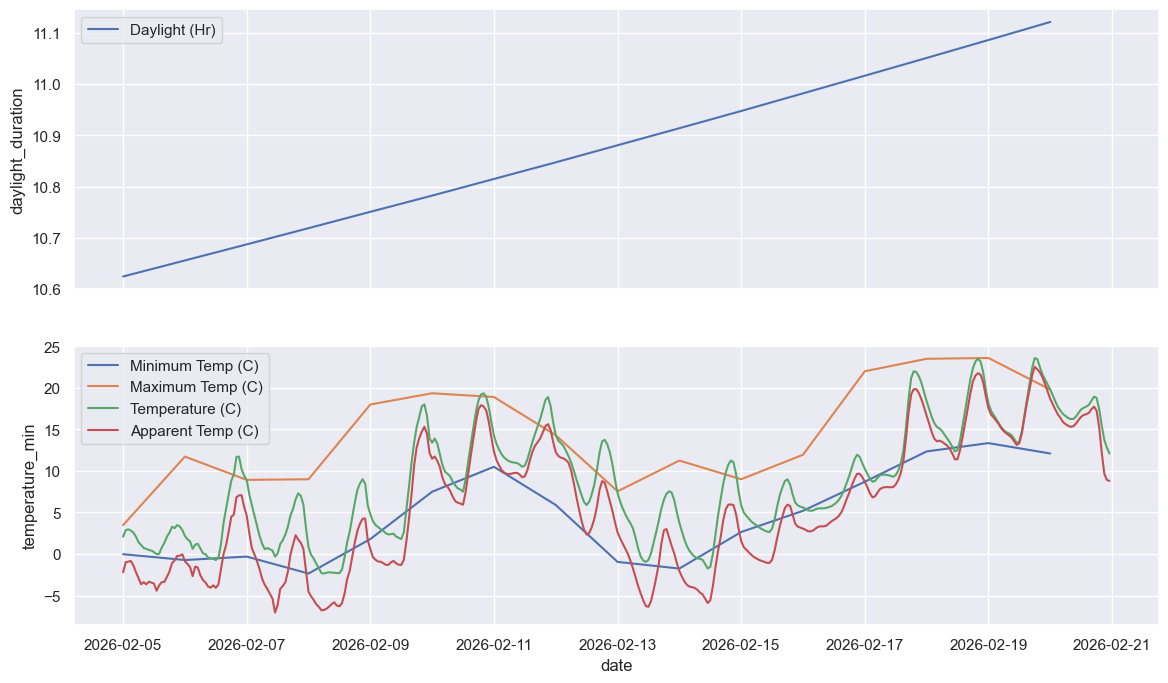

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
sns.lineplot(data=daily_dataframe, x='date',y='daylight_duration', ax=ax1, label = 'Daylight (Hr)')
sns.lineplot(data=daily_dataframe, x='date',y='temperature_min',ax=ax2, label = 'Minimum Temp (C)')
sns.lineplot(data=daily_dataframe, x='date',y='temperature_max',ax=ax2, label = 'Maximum Temp (C)')
sns.lineplot(data=hourly_dataframe, x='date',y='temperature_2m',ax=ax2, label = 'Temperature (C)')
sns.lineplot(data=hourly_dataframe, x='date',y='apparent_temperature',ax=ax2, label = 'Apparent Temp (C)')
plt.legend()
plt.show()